Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import random

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model



Data Import

In [5]:
#Giving the Directory name for dataset
data_directory = 'D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/MangoLeafBD Dataset'
#Giving name to the dataset for EDAs
dataset_name = 'Mango Leaf Disease Dataset'

In [6]:
#Function to get data paths and label
def get_data_paths(data_directory):
    
    #Initializing lists to store data paths and labels
    filepaths = []
    labels = []

    #Getting all the folders from the given directory
    folds = os.listdir(data_directory)

    #Looping through each folder whihch represents labels
    for fold in folds:
        foldpath = os.path.join(data_directory, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


#Calling the function
filepaths, labels = get_data_paths(data_directory)

In [7]:
#function to create one dataframe with both file paths and labels
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    
    return df

df = create_df(filepaths, labels)

In [8]:
#Printing the dataframe to check
df.head()

,filepaths,labels
0,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
1,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
2,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
3,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose
4,D:/Big Data Analytics/Term-2/BDM 3014 - Introd...,Anthracnose


In [9]:
#Function to check the datasize and classes inside the dataset
def num_from_dataset(df, name='df'):
    print(f"The {name} has {df.shape[0]} images.")
    print(f"The {name} has {len(df['labels'].unique())} classes")
num_from_dataset(df, dataset_name)

The Mango Leaf Disease Dataset has 4000 images.
The Mango Leaf Disease Dataset has 8 classes


In [10]:
#Function to count images inside particular labels
def classes_count(df, name='df'):
    
    print(f"The {name} has: ")

    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"'{name}' has {num_class} images")
        
classes_count(df, dataset_name)

The Mango Leaf Disease Dataset has: 

'Anthracnose' has 500 images
'Bacterial Canker' has 500 images
'Cutting Weevil' has 500 images
'Die Back' has 500 images
'Gall Midge' has 500 images
'Healthy' has 500 images
'Powdery Mildew' has 500 images
'Sooty Mould' has 500 images


Data Cleaning
- Checking for null values
- Handling missing values
- Checking for duplicate values

In [11]:
#Function for data cleaning
def data_cleaning(df, name='df'):
    #Checking for null values
    num_null_vals = sum(df.isnull().sum().values)

    #When there is no null values
    if not num_null_vals:
        print(f"The {name} has no null values")

    #When there i snull values
    else:
        print(f"The {name} has {num_null_vals} null values")
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        
        #Removes rows with null values
        df = df.dropna()
        print(f"\nRows with null values have been removed. The dataset now has {df.shape[0]} rows.")
    
    #Checking for duplicates
    num_duplicates = df.duplicated().sum()

    #When there is no duplication in dataset
    if num_duplicates == 0:
        print(f"\nThe {name} has no duplicate values.")
    
    #When there is duplication in dataset
    else:
        print(f"\nThe {name} has {num_duplicates} duplicate rows.")
        df = df.drop_duplicates()
        print(f"Duplicate rows have been removed. The dataset now has {df.shape[0]} rows.")

    return df

#Assiging new cleaned dataframe to the df
df = data_cleaning(df, dataset_name)


The Mango Leaf Disease Dataset has no null values

The Mango Leaf Disease Dataset has no duplicate values.


EDAs
Class distribution in dataset
- Shows the balance in dataset
- Helps model to be balanced and not biased towards any class

In [12]:
#Function to create graphs with class distribution in dataset
def class_distribution(dataframe, col_name):

    #Making subplots
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Percentage Plot', 'Total Count Plot'),
                        specs=[[{"type": "bar"}, {'type': 'scatter'}]])
    
    #Total counts in dataframe
    total_count = dataframe[col_name].value_counts().sum()
    #Percentage of particular label in dataframe
    percentage_values = (dataframe[col_name].value_counts().values / total_count) * 100

    #Creating bar plot
    fig.add_trace(go.Bar(y=percentage_values.tolist(),
                        x=[str(i) for i in dataframe[col_name].value_counts().index],
                        #Showing the values in percentage 
                        text=[f'{val:.2f}%' for val in percentage_values], 
                        textfont=dict(size=10),
                        name=col_name,
                        textposition='auto',
                        showlegend=False,
                        marker=dict(color=colors)),
                                )
    
    #Creating scatter plot
    fig.add_trace(go.Scatter(x=dataframe[col_name].value_counts().keys(),
                         y=dataframe[col_name].value_counts().values,
                         mode='markers',
                         text=dataframe[col_name].value_counts().keys(),
                         textfont=dict(size=10),
                         marker=dict(size=15, color=colors),
                         name=col_name),
              row=1, col=2)

    #Updating plot
    fig.update_layout(title={'text': 'Disease Distribution in Dataset',
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    

#Styling the plot with custom colours
colors = [
    '#3A506B', 
    '#8E8D8A',  
    '#D9BF77',  
    '#6A8D73',  
    '#B84A4A',  
    '#86B3D1',  
    '#B0C4B1',  
    '#9A5A6E',  
    '#C8A165',  
    '#7C6C8E'   
]

#Calling the function
class_distribution(df,'labels')

C:\Users\sudee\AppData\Local\Temp\ipykernel_17976\4089772672.py:16: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



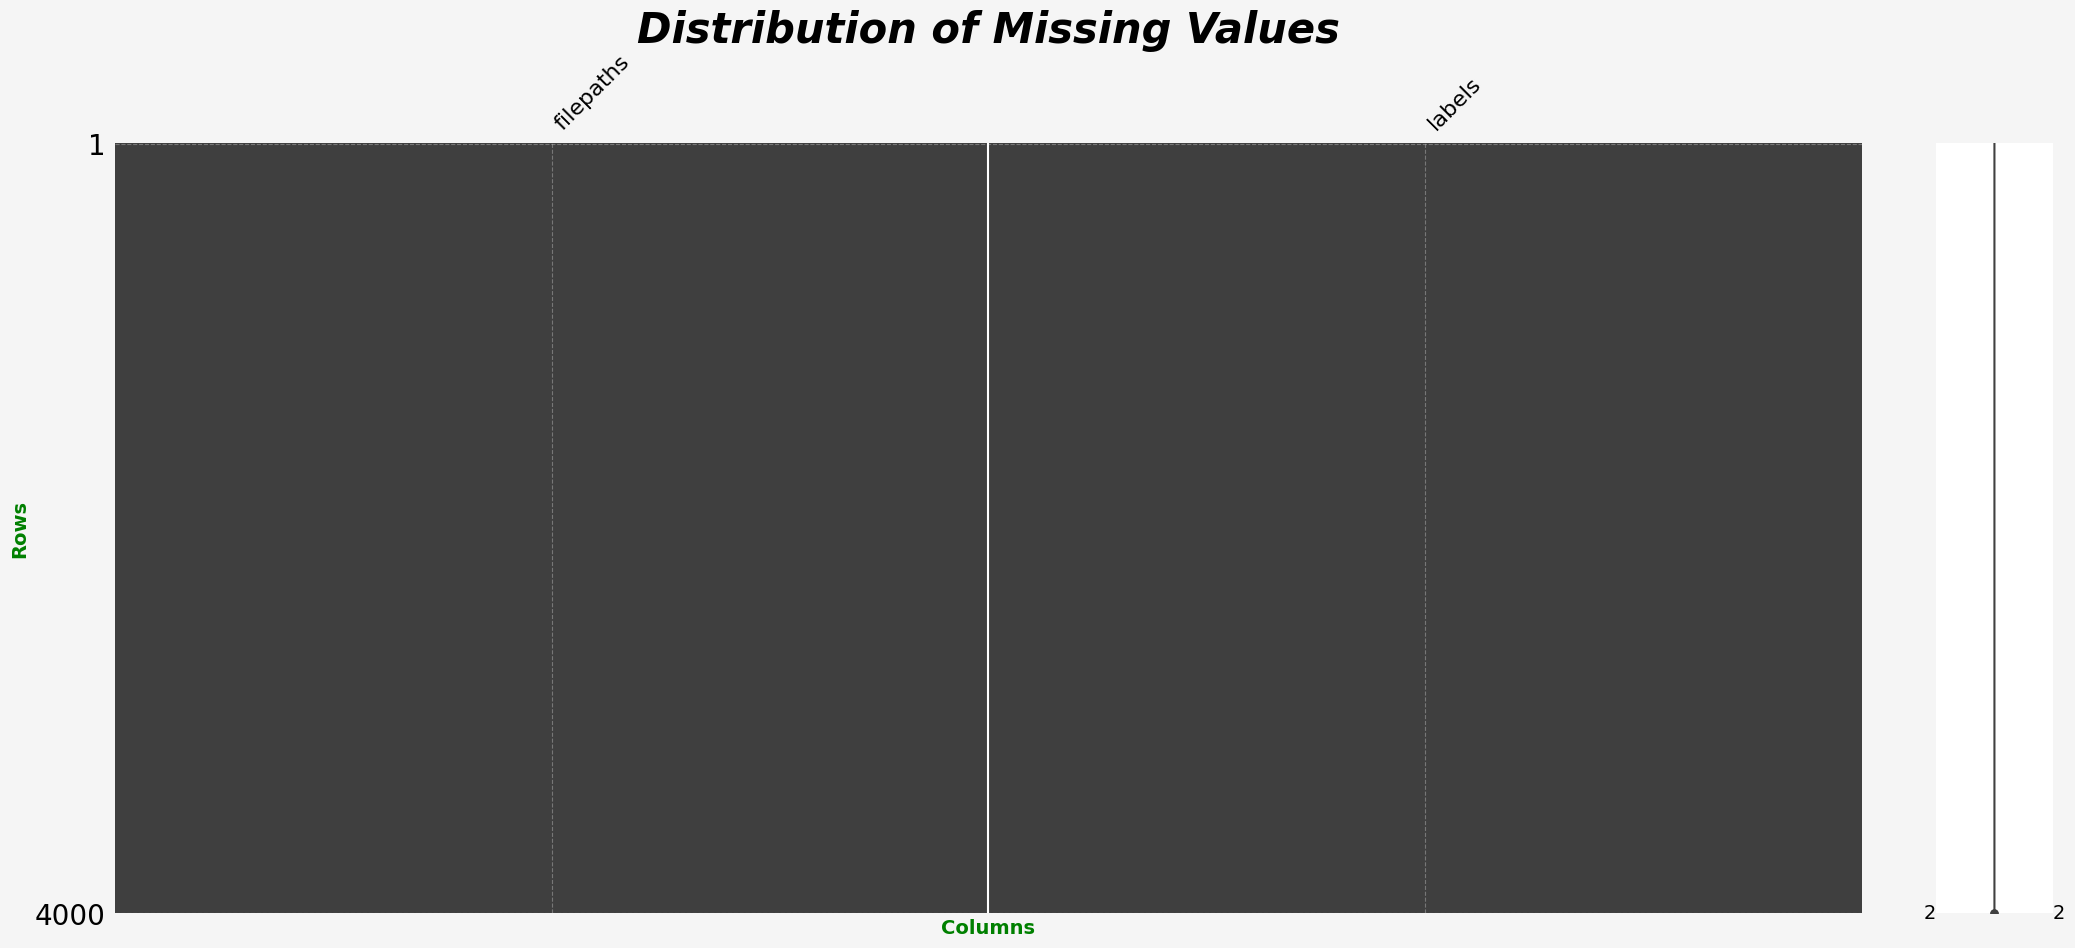

In [13]:

#Ploting the missing values matrix
msno.matrix(df)

#Setting Title and styles
plt.title('Distribution of Missing Values', fontsize=30, fontstyle='oblique', fontweight='bold')

#Custom fonts and colours
plt.xlabel('Columns', fontsize=14, fontweight='bold', color='green')
plt.ylabel('Rows', fontsize=14, fontweight='bold', color='green')

#Custom Background for the plot
plt.gcf().set_facecolor('whitesmoke')
plt.grid(True, linestyle='--', alpha=0.5)

#Adjusting of spacing layout
plt.tight_layout()

#Showing the plot
plt.show()

Pixel Intensity Distribution
- helps to understand the image better and see the features and patterns on the image
- helps to identify textures patterns
- help to differential objects in image

Selected Image: D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/MangoLeafBD Dataset\Anthracnose\IMG_20211011_161636 (Custom).jpg, Label: Anthracnose


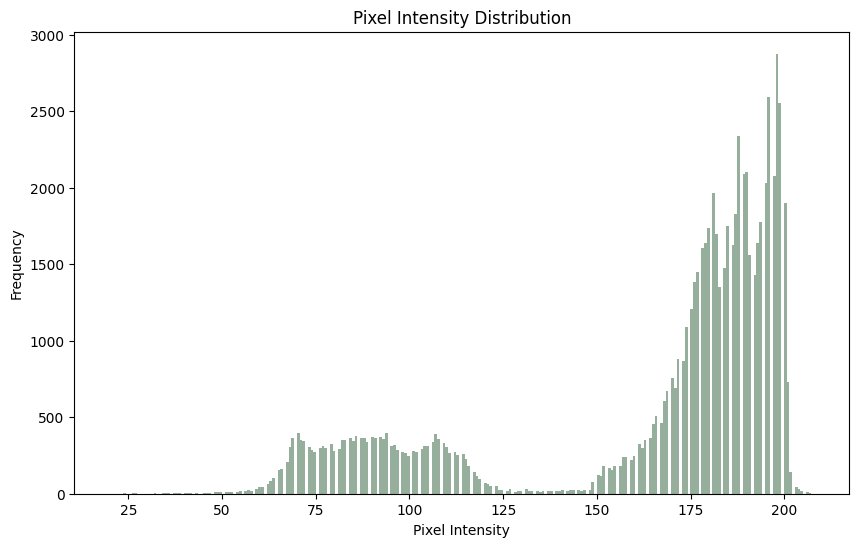

Image Statistics - Mean: 163.34067708333333, Standard Deviation: 41.45723834265726, Min: 20, Max: 208


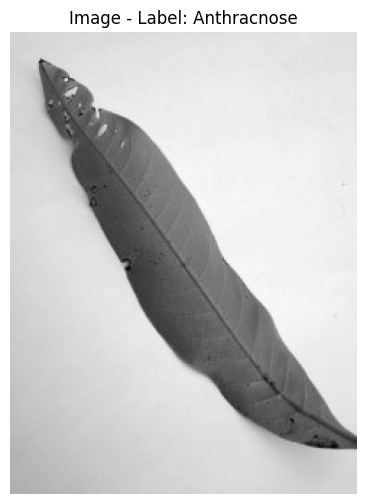

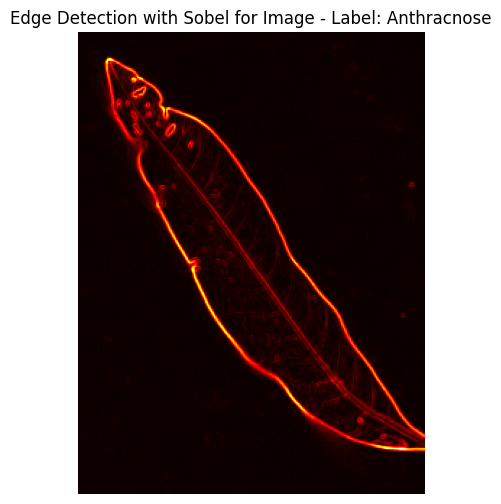

In [14]:
#Checking one image's pixel intensity and edge detection to see if its good

#Picking a random image from the DataFrame
ran_index = random.choice(df.index)
ran_filepath = df.loc[ran_index, 'filepaths']
ran_label = df.loc[ran_index, 'labels']

#Loading the selected image in grayscale
img = cv2.imread(ran_filepath, cv2.IMREAD_GRAYSCALE)

#Checking if the image was loaded properly
if img is not None:
    print(f"Selected Image: {ran_filepath}, Label: {ran_label}")
    
    #Pixel Intensity Distribution (Histogram) plot
    plt.figure(figsize=(10, 6))

    #Flatting the image array
    plt.hist(img.ravel(), bins=256, color='#6A8D73', alpha=0.7) 
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

    #Basic Statistics of Pixel Intensities
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    min_intensity = np.min(img)
    max_intensity = np.max(img)
    print(f"Image Statistics - Mean: {mean_intensity}, Standard Deviation: {std_intensity}, Min: {min_intensity}, Max: {max_intensity}")
    
    #Displaying the  Grey scale Image
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Image - Label: {ran_label}")
    plt.axis('off')
    plt.show()

    #Edge Detection Using Sobel Filter from opencv
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobel_x, sobel_y)

    #Visualizing the Edge Detected Image
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude, cmap='hot')
    plt.title(f"Edge Detection with Sobel for Image - Label: {ran_label}")
    plt.axis('off')
    plt.show()

else:
    print("Error loading the image!")


Train, Test, Validation Split

In [15]:
#Splitting data into training testing and validation
#Training dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

#validation and test dataframe
validation_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [16]:
#Function to check for size of datasets
def data_size(df, name='df'):
    print(f"Number of {name} is {len(df)} images")

In [17]:
#Training dataset size
data_size(train_df, 'Training '+dataset_name)

#Validation dataset size
data_size(validation_df, 'Validation '+dataset_name)

#Testing dataset size
data_size(test_df, 'Testing '+dataset_name)

Number of Training Mango Leaf Disease Dataset is 2800 images
Number of Validation Mango Leaf Disease Dataset is 600 images
Number of Testing Mango Leaf Disease Dataset is 600 images


Feature Engineering
- Image Normalization and Scaling
- Image Augmentation (Rotations, Brightness, Flips)
- Handling Input Sizes and Channels
- Batch Processing 

In [18]:

#Defining image and batch size parameters

#Number of images to be processed in a batch
batch_size = 40  
#Cropping image size (width, height) in pixels
img_size = (224, 224)
#Number of color channels (RGB)
channels = 3

#Shape of the input image
img_shape = (img_size[0], img_size[1], channels)

#Calculating custom test batch size based on test dataset length
ts_length = len(test_df) 

#Finding the optimal test batch size where number of steps is <= 80
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

#Calculating the number of steps per epoch for the test dataset
test_steps = ts_length // test_batch_size

#Custom scalar function to be used in the ImageDataGenerator; it returns the image without any changes
def scalar(img):
    return img

#Creating an ImageDataGenerator for training with data augmentation (rotation, shifting, zooming, flipping, etc.)
training_gen = ImageDataGenerator(preprocessing_function=scalar,  # Apply the scalar function to the images
                            #Data augmentation parameters
                            rotation_range=40,  
                            width_shift_range=0.2,  
                            height_shift_range=0.2,  
                            brightness_range=[0.4, 0.6],  
                            zoom_range=0.3, 
                            horizontal_flip=True, 
                            vertical_flip=True) 

#Creating a similar ImageDataGenerator for testing (no data augmentation, just scalar function)
#Appling the scalar function to the images
testing_gen = ImageDataGenerator(preprocessing_function=scalar,  
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            brightness_range=[0.4, 0.6],
                            zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True)

#Generating training data from a DataFrame
train_gen = training_gen.flow_from_dataframe(train_df,  #DataFrame with training data paths and labels
                                       #Column name for image file paths
                                       x_col='filepaths', 
                                       #Column name for image labels 
                                       y_col='labels',
                                       #Resize images to target size (224x224)  
                                       target_size=img_size,  
                                       #Class mode for categorical labels (multi-class classification)
                                       class_mode='categorical',
                                       #Load images as RGB (3 channels)  
                                       color_mode='rgb',
                                       #Shuffle the data for better training  
                                       shuffle=True,  
                                       #Number of images per batch
                                       batch_size=batch_size)  

#Generating validation data from a DataFrame
validation_gen = testing_gen.flow_from_dataframe(validation_df,  #DataFrame with validation data paths and labels
                                            x_col='filepaths',
                                            y_col='labels',
                                            target_size=img_size,
                                            class_mode='categorical',
                                            color_mode='rgb',
                                            shuffle=True,  #Shuffle validation data
                                            batch_size=batch_size)

#Generating test data from a DataFrame
#Using custom test_batch_size and no shuffling since the test data needs to be evaluated as it is
#DataFrame with test data paths and labels
test_gen = testing_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      #Do not shuffle test data
                                      shuffle=False,  
                                      #Custom test batch size calculated earlier
                                      batch_size=test_batch_size) 


Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


Checking batch sample from training data

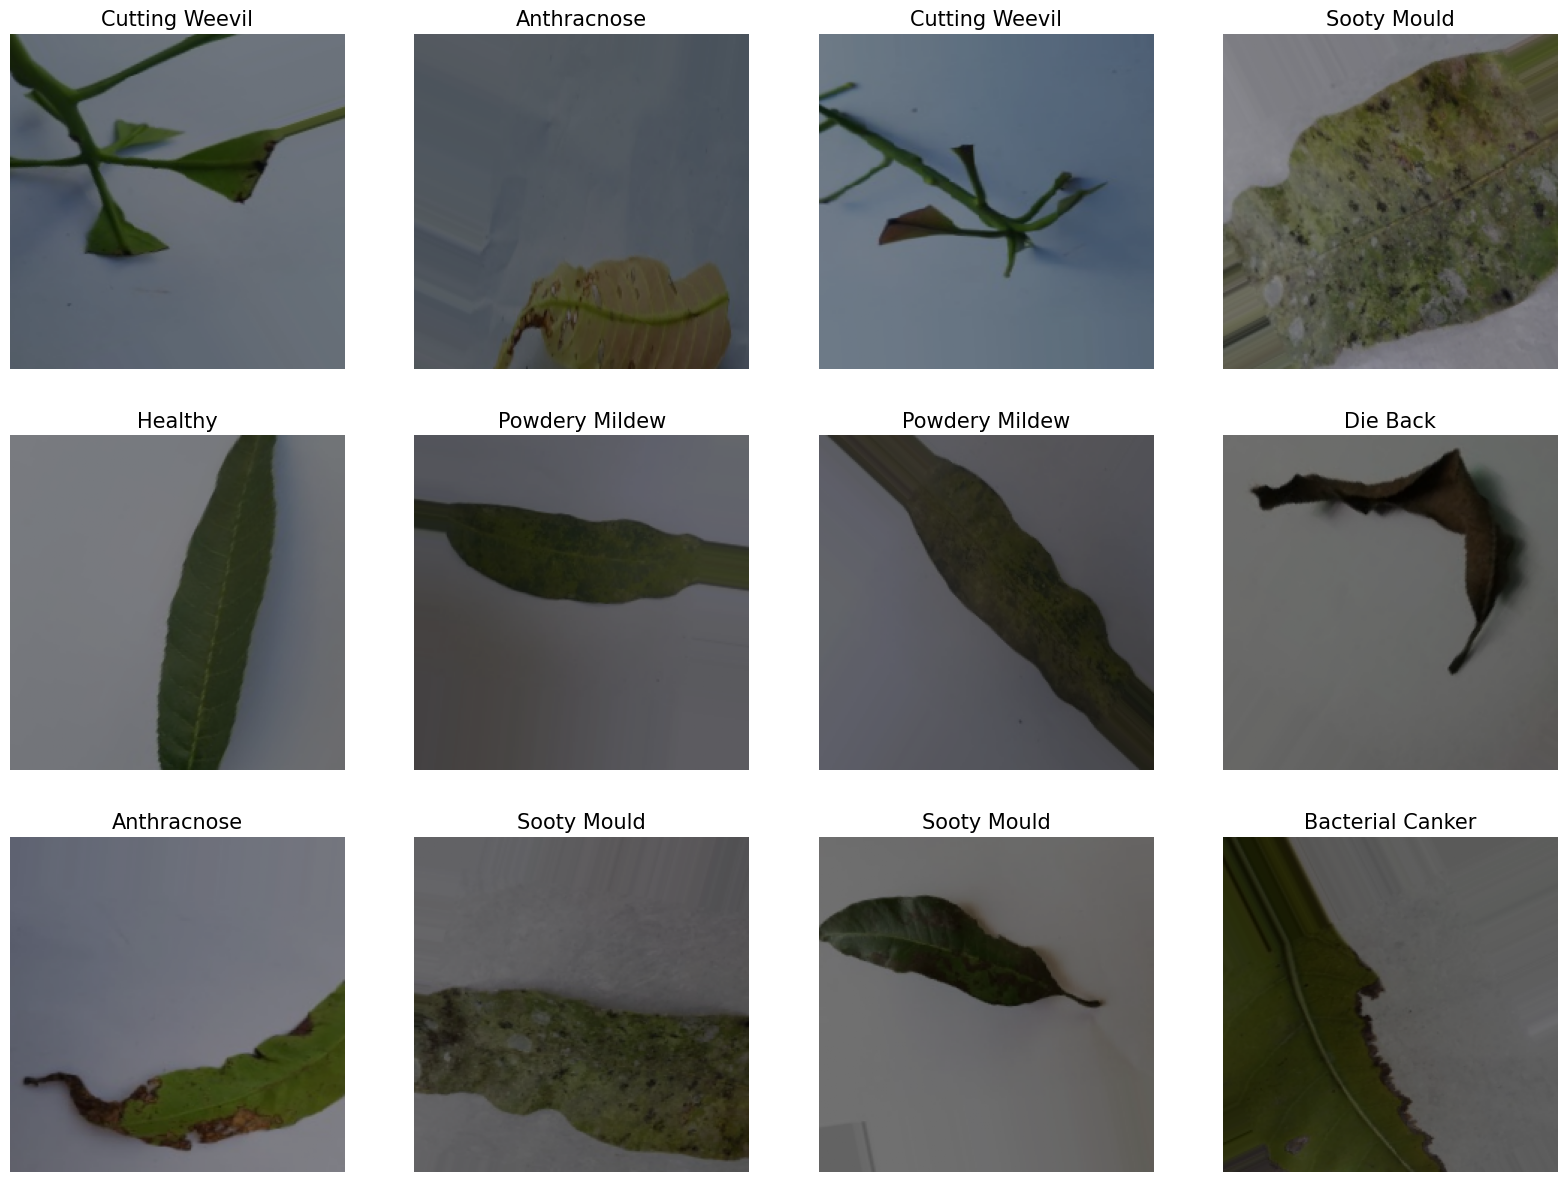

In [19]:
#defines dictionary {'class': index}
gen_dict = train_gen.class_indices   

#defines list of dictionary's kays (classes), classes names : string
classes = list(gen_dict.keys())

#get a batch size samples from the generator
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    #scaling data to range (0 - 255)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index] 
    plt.title(class_name, color= 'black', fontsize= 15)
    plt.axis('off')
    
plt.show()

Squential Model Building

In [ ]:
#Creating Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#to define number of classes in dense layer
class_count = len(list(train_gen.class_indices.keys())) 


#using efficientnetb0 from EfficientNet family.
#Simpler base model istead of complex one, 
#because small dataset and to stop overfitting

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

#Building a Sequential model with the EfficientNetB7 base
model = Sequential([
    #Adding the base model
    base_model,  

    #Normalizing inputs for faster training and convergence
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001), 
    #Adding a fully connected layer with 128 units 
    Dense(128,  
          #Adding L2 regularization to the weights
          kernel_regularizer=regularizers.l2(0.01), 
          #Adding L1 regularization to the activations 
          activity_regularizer=regularizers.l1(0.001), 
          #Adding L1 regularization to the biases 
          bias_regularizer=regularizers.l1(0.001),  
          #Using ReLU activation function
          activation='relu'), 
    #Dropout layer to prevent overfitting with a dropout rate of 45% 
    Dropout(rate=0.3, seed=123), 

    #Output layer with softmax activation for multi-class classification 
    Dense(class_count, activation='softmax')  
])

#Compiling the model
#Adamax is an adaptive learning rate optimizer based on Adam
#categorical_crossentropy is used as the loss function for multi-class classification
#Using Adamax optimizer with learning rate 0.0001
model.compile(optimizer=Adamax(learning_rate=0.0001),  
               #Loss function for categorical classification
              loss='categorical_crossentropy', 
              #Metric to monitor during training is accuracy
              metrics=['accuracy'])  

#Displaying the model architecture summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,691 (16.10 MB)

 Trainable params: 167,560 (654.53 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Putting Early Stop for training the data

In [18]:
#Setting up EarlyStopping callback
early_stopping = EarlyStopping(
    #Monitors the validation loss during training
    monitor='val_loss', 
    #If validation loss doesn't improve for 5 consecutive epochs, training stops early
    #Change is accordingly to the number of epochs you want to wait before stopping
    patience=5,  
    #Restores the model's best weights (with the lowest validation loss) after stopping
    restore_best_weights=True,
    #Looks for the minimum value of 'val_loss' (we want to minimize the loss)
    mode='min'  
)

Data Training with epochs 10 for initial training

In [ ]:
#Setting Bacth size fir training
batch_size = 16 

#Setting number of epochs for training
epochs = 100  

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = validation_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

c:\Users\sudee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.2416 - loss: 7.4819 - val_accuracy: 0.5133 - val_loss: 7.7311
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5067 - loss: 6.2678 - val_accuracy: 0.7333 - val_loss: 6.1086
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6717 - loss: 5.7902 - val_accuracy: 0.8000 - val_loss: 5.5382
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7323 - loss: 5.5009 - val_accuracy: 0.8167 - val_loss: 5.2705
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7844 - loss: 5.2963 - val_accuracy: 0.8650 - val_loss: 5.0180
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7988 - loss: 5.1093 - val_accuracy: 0.8833 - val_loss: 4.8911
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8256 - loss: 4.9712 - val_accuracy: 0.9100 - val_loss: 4.7237
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8367 - loss: 4.8391 - val_accuracy: 0.

Model Evaluation plots
- Training and Validation Loss
- Training and Validation Accuracy

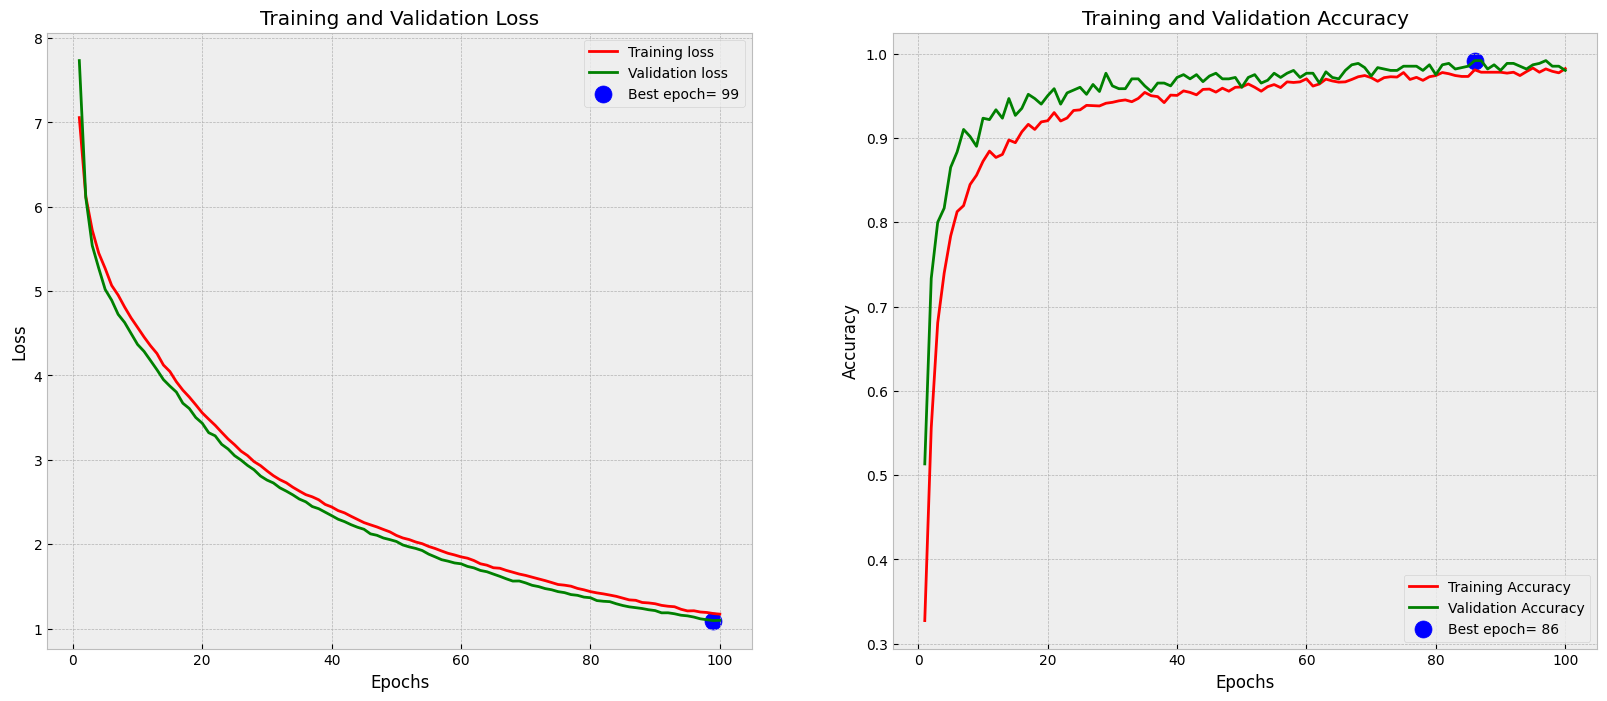

In [ ]:
#Define needed variables
training_acc = history.history['accuracy']
training_loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']
index_loss = np.argmin(validation_loss)
validation_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_acc)
acc_highest = validation_acc[index_acc]
Epochs = [i+1 for i in range(len(training_acc))]
loss_label = f'Best epoch= {str(index_loss + 1)}'
acc_label = f'Best epoch= {str(index_acc + 1)}'

#Plotting training history

plt.figure(figsize= (20, 8))
plt.style.use('bmh')

plt.subplot(1, 2, 1)
plt.plot(Epochs, training_loss, 'r', label= 'Training loss')
plt.plot(Epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, validation_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Loss and Accuracy:
- Training
- Validation
- Testing

In [21]:
test_length = len(test_df)
test_batch_size = max(sorted([test_length // n for n in range(1, test_length + 1) if test_length%n == 0 and test_length/n <= 80]))
test_steps = test_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validation_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9979 - loss: 1.0685
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9956 - loss: 1.0841


c:\Users\sudee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9877 - loss: 1.4885
Train Loss:  1.066455364227295
Train Accuracy:  0.996874988079071
--------------------
Validation Loss:  1.08376145362854
Validation Accuracy:  0.9937499761581421
--------------------
Test Loss:  1.4974197149276733
Test Accuracy:  0.9850000143051147


Prediction for Test

In [22]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step


Confustion Matrix for Prediction

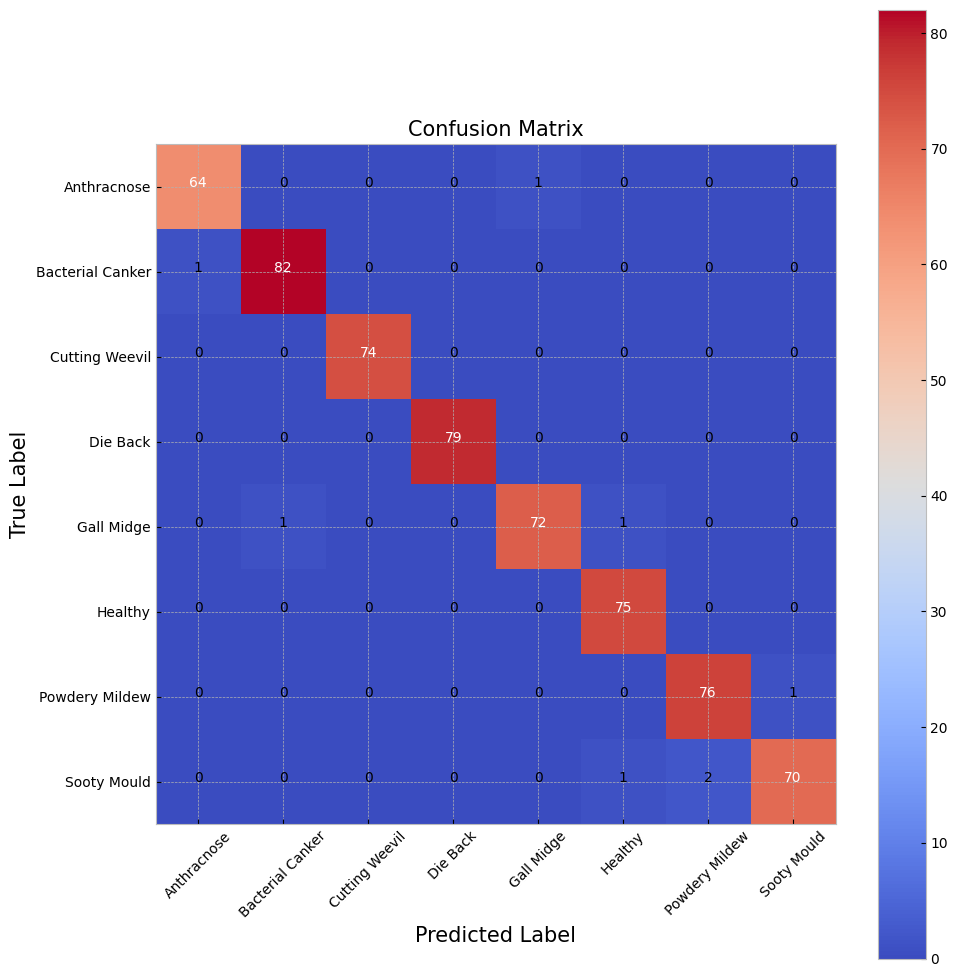

In [23]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))

#Picking plot style
plt.style.use('bmh')

#Colour theme
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45, fontsize=10)
plt.yticks(tick_marks, classes, fontsize=10)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)

plt.show()

Model Evaluation and Classification Report
- Precision
- Recall
- F1-score
- Support
- Accuracy 
- Macro Average
- Weighted Average

In [24]:
#Printing classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       0.98      0.98      0.98        65
Bacterial Canker       0.99      0.99      0.99        83
  Cutting Weevil       1.00      1.00      1.00        74
        Die Back       1.00      1.00      1.00        79
      Gall Midge       0.99      0.97      0.98        74
         Healthy       0.97      1.00      0.99        75
  Powdery Mildew       0.97      0.99      0.98        77
     Sooty Mould       0.99      0.96      0.97        73

        accuracy                           0.99       600
       macro avg       0.99      0.99      0.99       600
    weighted avg       0.99      0.99      0.99       600



Saving Model

In [ ]:
#Saving the model
model.save('model_v2.h5')


Model Interpretation With LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  1%|          | 10/1000 [00:04<06:39,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


  2%|▏         | 20/1000 [00:04<03:13,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  3%|▎         | 30/1000 [00:05<02:09,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  4%|▍         | 40/1000 [00:05<01:36,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


  5%|▌         | 50/1000 [00:06<01:14, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


  6%|▌         | 60/1000 [00:06<00:59, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


  7%|▋         | 70/1000 [00:06<00:50, 18.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


  8%|▊         | 80/1000 [00:07<00:44, 20.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


  9%|▉         | 90/1000 [00:07<00:40, 22.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 10%|█         | 100/1000 [00:07<00:37, 23.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 11%|█         | 110/1000 [00:08<00:35, 24.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 12%|█▏        | 120/1000 [00:08<00:34, 25.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 13%|█▎        | 130/1000 [00:09<00:36, 23.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 14%|█▍        | 140/1000 [00:09<00:35, 24.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 15%|█▌        | 150/1000 [00:09<00:35, 23.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 16%|█▌        | 160/1000 [00:10<00:35, 23.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 17%|█▋        | 170/1000 [00:10<00:33, 24.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 18%|█▊        | 180/1000 [00:11<00:32, 25.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 19%|█▉        | 190/1000 [00:11<00:31, 26.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 20%|██        | 200/1000 [00:11<00:29, 26.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 21%|██        | 210/1000 [00:12<00:29, 26.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 22%|██▏       | 220/1000 [00:12<00:28, 26.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 23%|██▎       | 230/1000 [00:12<00:29, 26.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 24%|██▍       | 240/1000 [00:13<00:30, 24.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 25%|██▌       | 250/1000 [00:13<00:30, 24.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 26%|██▌       | 260/1000 [00:14<00:30, 24.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 27%|██▋       | 270/1000 [00:14<00:29, 24.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 28%|██▊       | 280/1000 [00:14<00:29, 24.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 29%|██▉       | 290/1000 [00:15<00:28, 24.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 30%|███       | 300/1000 [00:15<00:29, 23.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 31%|███       | 310/1000 [00:16<00:29, 23.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 32%|███▏      | 320/1000 [00:16<00:29, 23.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 33%|███▎      | 330/1000 [00:17<00:28, 23.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 34%|███▍      | 340/1000 [00:17<00:27, 23.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 35%|███▌      | 350/1000 [00:17<00:27, 24.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 36%|███▌      | 360/1000 [00:18<00:26, 24.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 37%|███▋      | 370/1000 [00:18<00:26, 23.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 38%|███▊      | 380/1000 [00:19<00:25, 24.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 39%|███▉      | 390/1000 [00:19<00:25, 24.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 40%|████      | 400/1000 [00:19<00:24, 24.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 41%|████      | 410/1000 [00:20<00:23, 24.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 42%|████▏     | 420/1000 [00:20<00:23, 24.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 43%|████▎     | 430/1000 [00:21<00:22, 24.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 44%|████▍     | 440/1000 [00:21<00:22, 24.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 45%|████▌     | 450/1000 [00:21<00:22, 24.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 46%|████▌     | 460/1000 [00:22<00:22, 23.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 47%|████▋     | 470/1000 [00:22<00:21, 24.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 48%|████▊     | 480/1000 [00:23<00:21, 23.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 49%|████▉     | 490/1000 [00:23<00:21, 23.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 50%|█████     | 500/1000 [00:24<00:21, 23.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 51%|█████     | 510/1000 [00:24<00:20, 23.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 52%|█████▏    | 520/1000 [00:24<00:20, 23.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 54%|█████▍    | 538/1000 [00:25<00:15, 29.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 54%|█████▍    | 542/1000 [00:25<00:20, 22.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 55%|█████▌    | 550/1000 [00:26<00:21, 21.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 56%|█████▌    | 560/1000 [00:26<00:19, 22.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 57%|█████▋    | 570/1000 [00:27<00:18, 23.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 58%|█████▊    | 580/1000 [00:27<00:17, 23.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 59%|█████▉    | 590/1000 [00:27<00:17, 24.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 60%|██████    | 600/1000 [00:28<00:17, 23.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 61%|██████    | 610/1000 [00:28<00:16, 23.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 62%|██████▏   | 620/1000 [00:29<00:15, 24.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 63%|██████▎   | 630/1000 [00:29<00:15, 24.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 64%|██████▍   | 640/1000 [00:29<00:14, 24.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 65%|██████▌   | 650/1000 [00:30<00:14, 24.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 66%|██████▌   | 660/1000 [00:30<00:13, 24.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 67%|██████▋   | 670/1000 [00:31<00:13, 24.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 68%|██████▊   | 680/1000 [00:31<00:12, 24.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 69%|██████▉   | 690/1000 [00:31<00:12, 24.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 70%|███████   | 700/1000 [00:32<00:12, 24.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 71%|███████   | 710/1000 [00:32<00:11, 24.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 72%|███████▏  | 720/1000 [00:33<00:11, 24.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 73%|███████▎  | 730/1000 [00:33<00:11, 23.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 74%|███████▍  | 740/1000 [00:34<00:10, 23.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 75%|███████▌  | 750/1000 [00:34<00:10, 23.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 76%|███████▌  | 760/1000 [00:34<00:09, 24.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 77%|███████▋  | 770/1000 [00:35<00:09, 24.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 78%|███████▊  | 780/1000 [00:35<00:09, 24.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 79%|███████▉  | 790/1000 [00:36<00:08, 24.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 80%|████████  | 800/1000 [00:36<00:08, 24.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 81%|████████  | 810/1000 [00:36<00:07, 24.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 82%|████████▏ | 820/1000 [00:37<00:07, 24.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 83%|████████▎ | 830/1000 [00:37<00:06, 24.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 84%|████████▍ | 840/1000 [00:38<00:06, 24.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 86%|████████▌ | 859/1000 [00:38<00:04, 30.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 86%|████████▋ | 864/1000 [00:39<00:05, 24.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 87%|████████▋ | 870/1000 [00:39<00:06, 21.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 88%|████████▊ | 880/1000 [00:39<00:05, 22.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 89%|████████▉ | 890/1000 [00:40<00:04, 22.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 90%|█████████ | 900/1000 [00:40<00:04, 23.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 91%|█████████ | 910/1000 [00:41<00:03, 23.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 92%|█████████▏| 920/1000 [00:41<00:03, 23.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 93%|█████████▎| 930/1000 [00:41<00:02, 23.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 94%|█████████▍| 940/1000 [00:42<00:02, 23.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 95%|█████████▌| 950/1000 [00:42<00:02, 23.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 96%|█████████▌| 960/1000 [00:43<00:01, 23.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 97%|█████████▋| 970/1000 [00:43<00:01, 24.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 98%|█████████▊| 980/1000 [00:44<00:00, 22.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 99%|█████████▉| 990/1000 [00:44<00:00, 22.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


100%|██████████| 1000/1000 [00:45<00:00, 22.15it/s]



LIME Explanation Results:
Top Label for Explanation: 0
Explanation of Important Features:
Feature 1: 24 with weight: 0.0944
Feature 2: 67 with weight: 0.0834
Feature 3: 41 with weight: 0.0828
Feature 4: 37 with weight: 0.0738
Feature 5: 75 with weight: 0.0616
Feature 6: 27 with weight: 0.0567
Feature 7: 28 with weight: 0.0459
Feature 8: 40 with weight: 0.0457
Feature 9: 21 with weight: 0.0339
Feature 10: 65 with weight: 0.0333
Feature 11: 71 with weight: 0.0328
Feature 12: 77 with weight: 0.0322
Feature 13: 62 with weight: 0.0289
Feature 14: 11 with weight: 0.0277
Feature 15: 9 with weight: 0.0260
Feature 16: 43 with weight: 0.0259
Feature 17: 88 with weight: -0.0246
Feature 18: 66 with weight: 0.0245
Feature 19: 56 with weight: 0.0243
Feature 20: 23 with weight: 0.0196
Feature 21: 31 with weight: -0.0190
Feature 22: 26 with weight: 0.0178
Feature 23: 58 with weight: 0.0174
Feature 24: 64 with weight: 0.0172
Feature 25: 84 with weight: -0.0164
Feature 26: 53 with weight: 0.0162
Featur

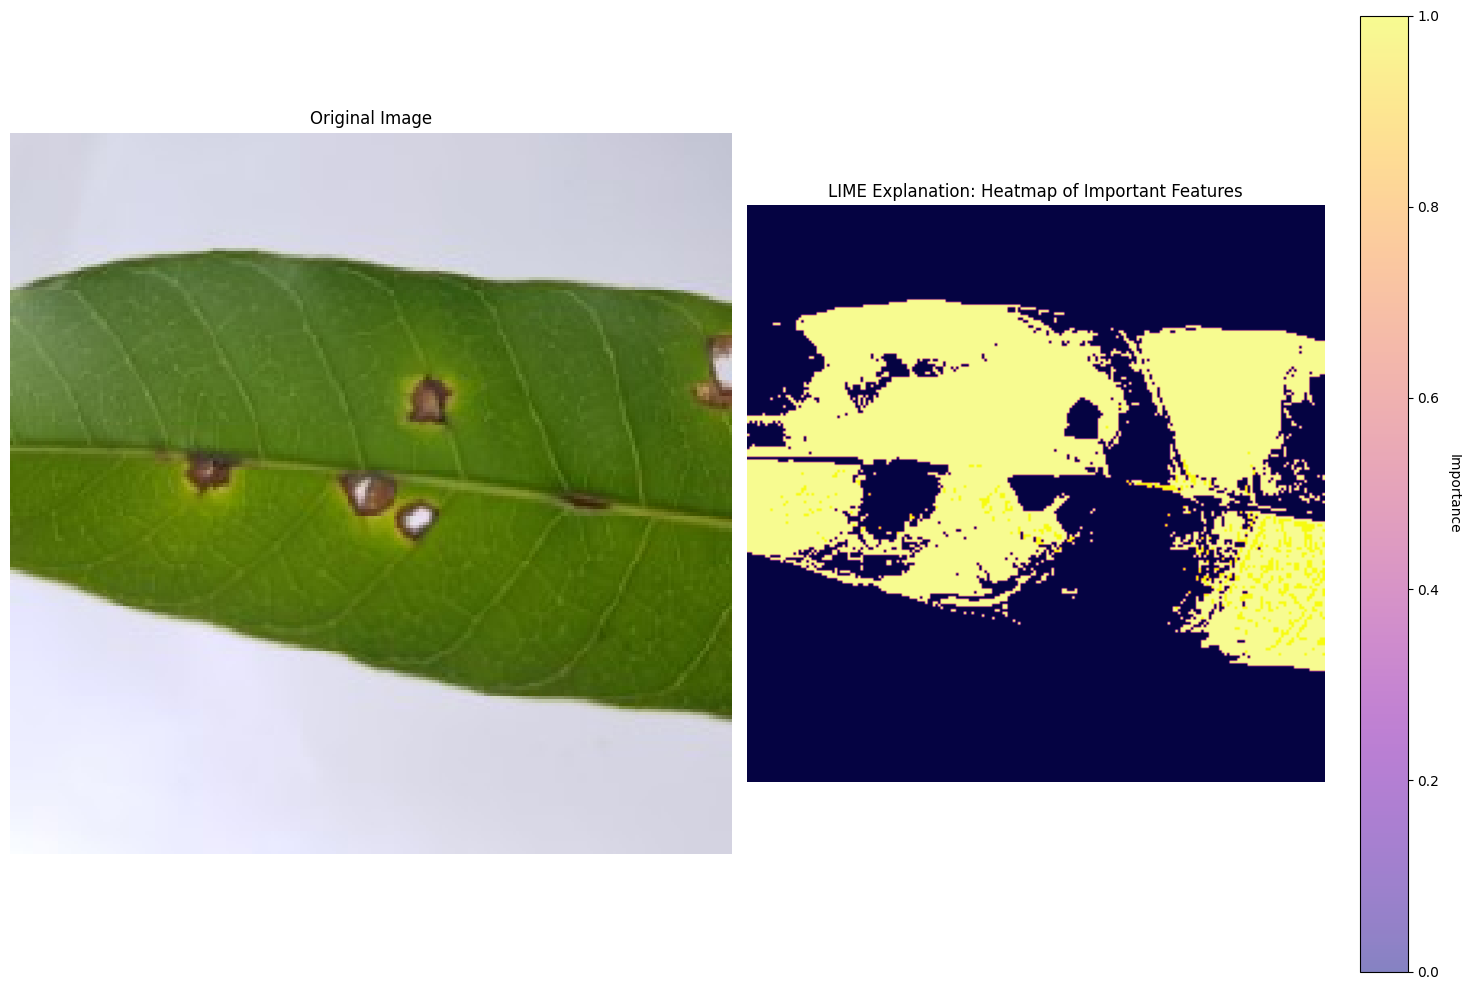

In [ ]:
from lime.lime_image import LimeImageExplainer

#Loading the saved model
model = load_model('model_v2.h5')

#Loading and preprocessing the image for model
img_path = 'D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/20211011_133423 (Custom).jpg'
#Resizing image to match input size
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
#Adding batch dimension
img_array = np.expand_dims(img_array, axis=0)  

#Preprocessing image as required by EfficientNetB0
img_array_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_array)

#Creating a LIME image explainer
explainer = LimeImageExplainer()

#Generating explanation using LIME
explanation = explainer.explain_instance(
    #Input image
    img_array[0], 
    #Prediction  with model
    model.predict, 
    #Number of top labels to explain (for classification) 
    top_labels=5, 
    #Color to hide (use 0 for default) 
    hide_color=0,
    #Number of random samples to generate for explanation  
    num_samples=1000  
)

#Visualizing the explanation as an image overlay (heatmap)
#Creating two subplots side by side with original image and LIME explainer image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  

#Original Image
axes[0].imshow(np.array(img)) 
axes[0].set_title('Original Image')
axes[0].axis('off')

#LIME Explanation Heatmap
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True,
    #Number of important features to highlight 
    num_features=10,  
    hide_rest=True
)
#Displaying the original image (for context)
axes[1].imshow(temp)  
#Overlayying the heatmap with plasma colormap
heatmap = axes[1].imshow(mask, cmap='plasma', alpha=0.5)  
axes[1].set_title('LIME Explanation: Heatmap of Important Features')
axes[1].axis('off')

#Adding color bar (legend)
cbar = fig.colorbar(heatmap, ax=axes[1], orientation='vertical')
cbar.set_label('Importance', rotation=270, labelpad=15)

#Printing the LIME explanation details
print("\nLIME Explanation Results:")
print("Top Label for Explanation:", explanation.top_labels[0])
print("Explanation of Important Features:")
for i, (feature, weight) in enumerate(explanation.local_exp[explanation.top_labels[0]]):
    print(f"Feature {i+1}: {feature} with weight: {weight:.4f}")

#Showing the plot
#Adjusting layout to prevent overlay
plt.tight_layout()  
plt.show()

Using Saved Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


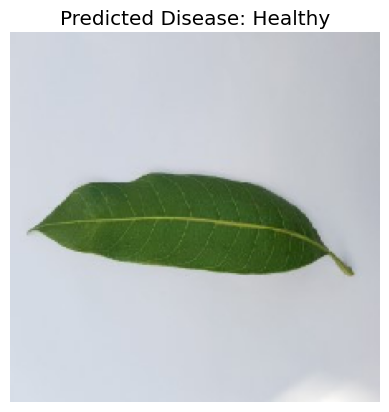

In [ ]:

def predict_and_display(image_path, model, class_labels):
    #Loading and preprocessing the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    #Making a prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    #Getting the class name from the manually defined list of class labels
    predicted_class_label = class_labels[predicted_class_index]

    #Displaying the predicted class name
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Disease: {predicted_class_label}")
    plt.show()

#Loading trained model
model.load_weights('D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/Development/prediction_model_v2.weights.h5')

#Define your class labels (in order)
class_labels = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']  # Replace with your actual class names

#Image path to test the model
image_path_to_test = 'D:/Big Data Analytics/Term-2/BDM 3014 - Introduction to Artificial Intelligence 01/Final Project/20211231_123327 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)


UI with Streamlit

In [ ]:
import streamlit as st
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from tensorflow.keras.models import load_model
import firebase_admin
from firebase_admin import credentials, firestore

#Caching the model and Firebase initialization for faster operations
@st.cache_resource
def load_firebase():
    #Initialize Firebase only if it hasn't been initialized already to avoid duplicate initialization
    if not firebase_admin._apps:
        #Firebase credential from the directory
        cred = credentials.Certificate("#Add gcp key")
        firebase_admin.initialize_app(cred)
    return firestore.client()

#Custom CSS for Streamlit app
st.markdown("""
    <style>
        .main-container {
            width: 90%;
            margin: auto;
            padding: 20px;
            background-color: #f0f2f6;
            border-radius: 10px;
            box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);
        }
        .header {
            font-size: 36px;
            font-weight: bold;
            color: #1f77b4;
            text-align: center;
            margin-bottom: 20px;
        }
        .description, .how-it-works {
            color: #333;
            font-size: 18px;
            text-align: justify;
        }
        .image-container {
            text-align: center;
            margin-bottom: 20px;
        }
        .how-it-works-header {
            font-size: 24px;
            font-weight: bold;
            color: #333;
            margin-top: 20px;
            text-align: justify;
        }
        .content-container {
            display: flex;
            justify-content: space-around;
            align-items: center;
            flex-wrap: wrap;
        }
        .column {
            flex: 1;
            margin: 10px;
            max-width: 48%;
        }
        @media screen and (max-width: 1200px) {
            .column {
                max-width: 100%;
                margin-bottom: 20px;
            }
        }
    </style>
""", unsafe_allow_html=True)


#Caching the model for faster predictions
@st.cache_resource
def load_trained_model():
    model = load_model('model_v2.h5')
    return model

#Caching the labels 
def load_class_labels():
    class_labels = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
    return class_labels


#Function to fetch disease details from Firestore
def get_disease_details(disease_name, db):
    #Matching disease name with the document name in Firestore
    doc_ref = db.collection('diseases').document(disease_name)  
    doc = doc_ref.get()
    #Condition to implement only if the document exists in Firestore
    if doc.exists:
        disease_data = doc.to_dict()
        name = disease_data.get('name', 'Unknown')
        desc = disease_data.get('desc', 'No description available.')
        symptoms = disease_data.get('symptoms', 'No symptoms available.')
        soln = disease_data.get('soln', 'No control solution available.')
        return name, desc, symptoms, soln
    else:
        return disease_name, "Overview not available.", "Symptoms not available.", "Control solution not available."

#Getting prediction using the trained model
#This function takes 3 inputs: image, model, and class labels
def predict_and_display(img, model, class_labels):
    #Ensuring the image has 3 channels (RGB); if it doesn't, convert the image
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    #Resizing the image to the required size
    img = img.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    #Prediction with model
    prediction = model.predict(img_array)
    #Prediction index with model
    predicted_class_index = np.argmax(prediction)
    #Prediction class based on index
    predicted_class_label = class_labels[predicted_class_index]
    #Prediction confidence
    confidence_percentage = 100 * np.max(prediction)

    #Returning label and confidence percentage
    return predicted_class_label, confidence_percentage


def main():
    #Streamlit layout with centered header
    st.markdown("<div class='main-container'><div class='header'>FarmAI</div>", unsafe_allow_html=True)

    #How it works section for UI
    st.markdown("<div class='how-it-works-header'><strong>How it Works</strong></div>", unsafe_allow_html=True)
    st.markdown("""
    <div class='how-it-works'>
        1. <strong>Upload an Image</strong>: Select an image of a mango leaf showing symptoms of a potential disease.<br>
        2. <strong>Disease Overview</strong>: Once the image is uploaded, the app displays information about the detected disease, including a description and symptoms.<br>
        3. <strong>Compare Symptoms</strong>: Compare the visible symptoms on the leaf with those provided to determine if further action may be needed.
    </div>
    """, unsafe_allow_html=True)

    st.markdown("<div class='description'>Upload an image of a mango leaf to view information about the detected disease.</div>", unsafe_allow_html=True)

    #File uploader to upload image with Streamlit
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

    #If an image is uploaded
    if uploaded_file is not None:
        #Initializing Firebase and model
        db = load_firebase()
        model = load_trained_model()
        class_labels = load_class_labels()
        
        image = Image.open(uploaded_file)
        
        st.markdown("<div class='content-container'>", unsafe_allow_html=True)
        
        #Creating two responsive columns
        col1, col2 = st.columns(2, gap="large")

        with col1:
            st.markdown("<div class='column image-container'>", unsafe_allow_html=True)
            #Displaying the uploaded image and the predicted disease with confidence
            st.image(image, caption="Uploaded Leaf Image", use_column_width=True)

            
            #Performing disease prediction and display the results
            predicted_class_label, confidence_percentage = predict_and_display(image, model, class_labels)
            
            #Condition where the confidence is low, and can't predict the disease properly for the given image
            if confidence_percentage < 30:
                st.write("Couldn't identify the disease with sufficient confidence from this image. Please upload a clearer image.")
            #When confidence is above threshold
            else:
                st.write(f"Predicted Disease: **{predicted_class_label}**")
                st.write(f"Confidence: **{confidence_percentage:.2f}%**")
            st.markdown("</div>", unsafe_allow_html=True)

        #Column 2 when the confidence is above the set threshold
        if confidence_percentage >= 30:
            with col2:
                st.markdown("<div class='column'>", unsafe_allow_html=True)
                #Fetching disease details from Firestore
                disease_name, overview, symptoms, soln = get_disease_details(predicted_class_label, db)
                
                #Showing the Disease Name on UI
                st.markdown(f"<div class='description'><strong>Disease Name:</strong> {disease_name}</div><br>", unsafe_allow_html=True)
                #Overview
                st.markdown(f"<div class='description'><strong>Overview:</strong> {overview}</div><br>", unsafe_allow_html=True)
                #Symptoms
                st.markdown(f"<div class='description'><strong>Symptoms:</strong> {symptoms}</div><br>", unsafe_allow_html=True)
                #Control
                st.markdown(f"<div class='description'><strong>Control:</strong> {soln}</div>", unsafe_allow_html=True)
                st.markdown("</div>", unsafe_allow_html=True)
        
        st.markdown("</div>", unsafe_allow_html=True)

    #Closing main-container
    st.markdown("</div>", unsafe_allow_html=True)

#Running the main
if __name__ == "__main__":
    main()


2024-12-05 17:46:08.474 
  command:

    streamlit run C:\Users\sudee\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]


Deployment with Flask 

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import numpy as np
import io

app = Flask(__name__)

#Loading the trained model
model = load_model('model_v2.h5')

#Defining classes from the dataset
class_labels = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']

#Define the prediction and display function
def predict_and_display(img, model, class_labels):
    #Resize the image to the required input shape
    img = img.resize((224, 224))

    #Preprocess the image
    #image to array using keras
    img_array = keras_image.img_to_array(img)
    #Expanding dimensions to match model inpu
    img_array = np.expand_dims(img_array, axis=0) 
    #Preprocessing the image as required by EfficientNett
    img_array = preprocess_input(img_array)  

    #Making a prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    #Getting the class name from the defined list of class labels
    predicted_class_label = class_labels[predicted_class_index]

    #Getting the confidence percentage for the predicted class
    confidence_percentage = 100 * np.max(prediction)

    #Printing the class index for debugging
    print(f"Predicted Class Index: {predicted_class_index}")
    
    #Return prediction details
    #Converting the index to int for JSON
    return predicted_class_label, int(predicted_class_index), confidence_percentage


#Defining the API route for image prediction
@app.route('/predict', methods=['POST'])
def predict():
    #handling missing file from API request
    if 'image' not in request.files:
        return jsonify({"error": "No file part in the request"}), 400

    #Getting the file from the request
    file = request.files['image']
    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    #Opening and processing the image
    try:
        img = Image.open(file.stream)
        predicted_class_label, predicted_class_index, confidence_percentage = predict_and_display(img, model, class_labels)

        #Returning the prediction as JSON
        return jsonify({
            'predicted_class': predicted_class_label,
            'predicted_class_index': predicted_class_index,
            'confidence_percentage': confidence_percentage
        })
    #Raising an exception if the image cannot be processed, with error code
    except Exception as e:
        return jsonify({"error": f"Error processing the image: {str(e)}"}), 500

#Defiing home route for API endpoint
@app.route('/')
def home():
    return "Welcome to the Image Classification API! Use the /predict endpoint to upload an image for prediction."

#running the api
if __name__ == '__main__':
    app.run(debug=True)
